## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_palette("Paired")
plt.rcParams["figure.facecolor"] = "white"

In [4]:
specter2_df = pd.read_csv('specter2_chunking_strategies_comparison2.csv',index_col=0)
specter_df = pd.read_csv('specter_chunking_strategies_comparison2.csv',index_col=0)
scincl_df = pd.read_csv('scincl_chunking_strategies_comparison2.csv',index_col=0)
scibert_df = pd.read_csv('scibert_chunking_strategies_comparison2.csv',index_col=0)
pubmedbert_df = pd.read_csv('pubmedbert_chunking_strategies_comparison2.csv',index_col=0)

cols_to_drop = ['recall_std', 'precision_std', 'iou_std', 'mrr_std']

dataframes = [specter2_df, specter_df, scincl_df, scibert_df, pubmedbert_df]

dataframes_processed = [df.drop(columns=cols_to_drop, errors='ignore') for df in dataframes]

specter2_df, specter_df, scincl_df, scibert_df, pubmedbert_df = dataframes_processed

runtime_metrics_df = pd.read_csv('runtime_metrics_cosine.csv')

In [5]:
specter2_df.head()

,strategy,recall_mean,precision_mean,iou_mean,hit_rate,mrr_mean
0,recursive_cs256_co0,0.415171,0.087457,0.078703,0.327801,0.326141
1,recursive_cs500_co0,0.455915,0.047725,0.045406,0.378976,0.386676
2,recursive_cs256_co25,0.425295,0.088285,0.079757,0.334716,0.328077
3,recursive_cs500_co50,0.446436,0.047177,0.044905,0.359613,0.368396
4,semantic,0.286088,0.046260,0.035373,0.182573,0.194329


In [6]:
runtime_metrics_df.head()

,embedding_model,strategy,chunking_time_s,num_chunks,embedding_faiss_time_s,search_time_s,metrics_time_s,total_embedding_model_time_s
0,specter2,recursive_cs256_co0,0.33,70580,173.71,13.08,0.05,1897.44
1,specter2,recursive_cs500_co0,0.30,32326,160.35,5.82,0.10,1897.44
2,specter2,recursive_cs256_co25,0.31,71094,172.71,12.94,0.05,1897.44
3,specter2,recursive_cs500_co50,0.30,32787,159.45,5.89,0.09,1897.44
4,specter2,semantic,1033.89,17054,150.48,3.08,0.11,1897.44


In [7]:
code_to_strategy_num_mapping = {'recursive_cs256_co0': 'S1', 
                                'recursive_cs500_co0': 'S2', 
                                'recursive_cs256_co25': 'S3', 
                                'recursive_cs500_co50': 'S4', 
                                'semantic': 'S5'}
strategy_num_to_description_mapping = {'S1': 'Strategy Type: Recursive Splitting\nChunk Size: 256\nChunk Overlap: 0', 
                                       'S2': 'Strategy Type: Recursive Splitting\nChunk Size: 512\nChunk Overlap: 0', 
                                       'S3': 'Strategy Type: Recursive Splitting\nChunk Size: 256\nChunk Overlap: 25', 
                                       'S4': 'Strategy Type: Recursive Splitting\nChunk Size: 512\nChunk Overlap: 50', 
                                       'S5': 'Strategy Type: Semantic Chunking\nBreakpoint Type: Percentile\nThreshold: 90'}

In [8]:
specter2_df['strategy']

0     recursive_cs256_co0
1     recursive_cs500_co0
2    recursive_cs256_co25
3    recursive_cs500_co50
4                semantic
Name: strategy, dtype: object

In [9]:
[code_to_strategy_num_mapping[strategy] for strategy in specter2_df['strategy']]

['S1', 'S2', 'S3', 'S4', 'S5']

In [10]:
runtime_metrics_df[runtime_metrics_df['embedding_model']=='specter2'][['strategy','search_time_s']]

,strategy,search_time_s
0,recursive_cs256_co0,13.08
1,recursive_cs500_co0,5.82
2,recursive_cs256_co25,12.94
3,recursive_cs500_co50,5.89
4,semantic,3.08


## Quality Metrics Comparison

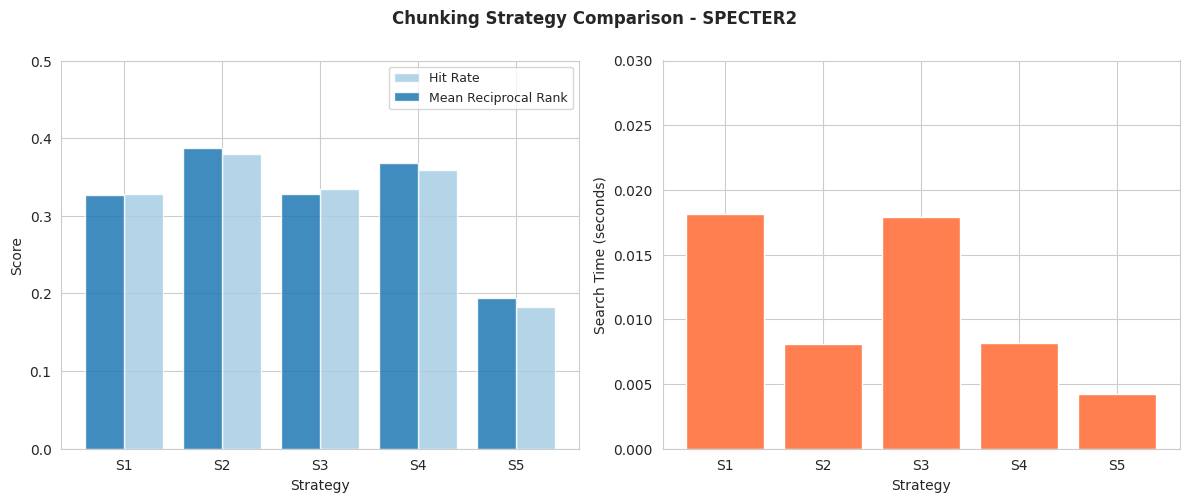

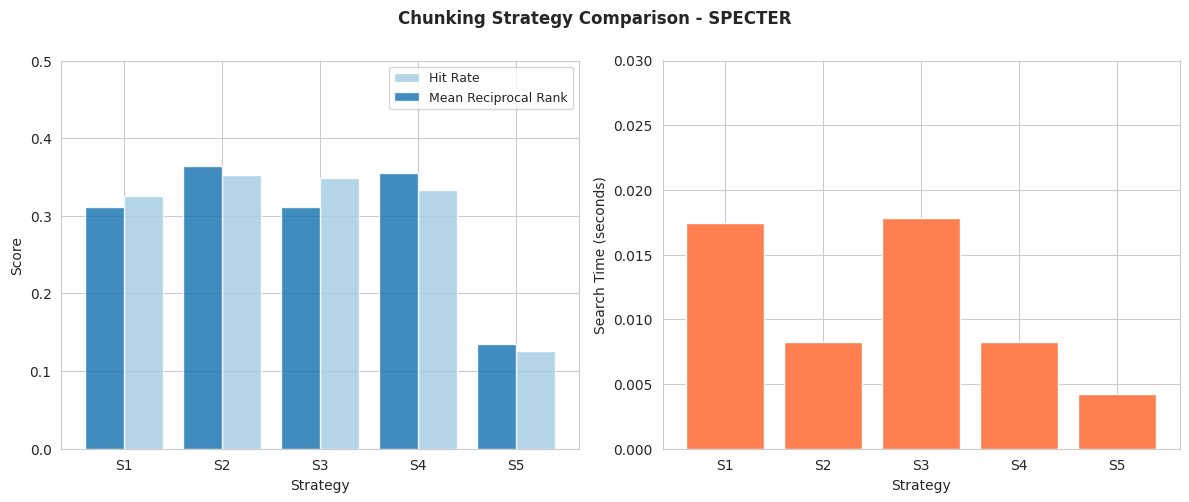

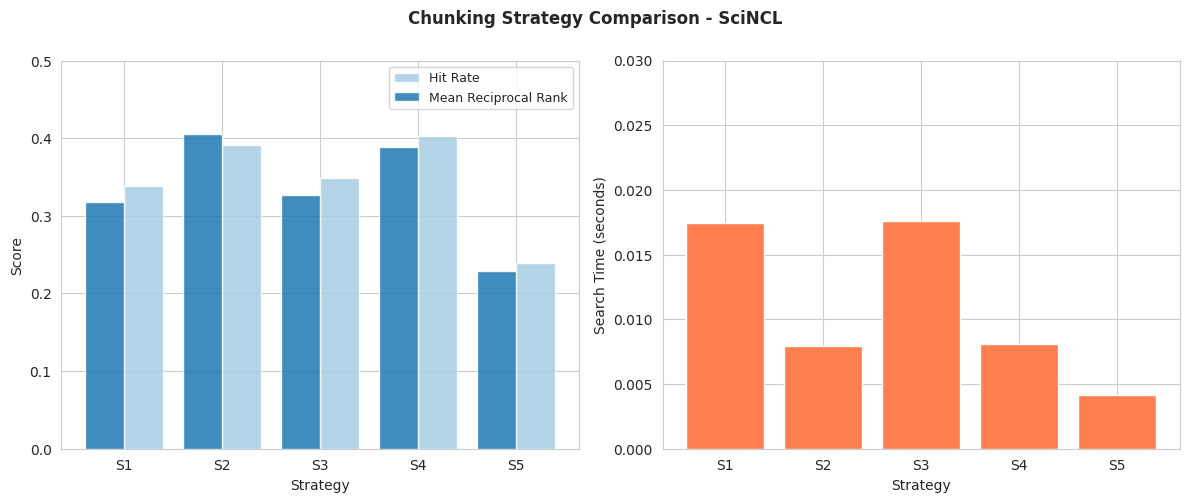

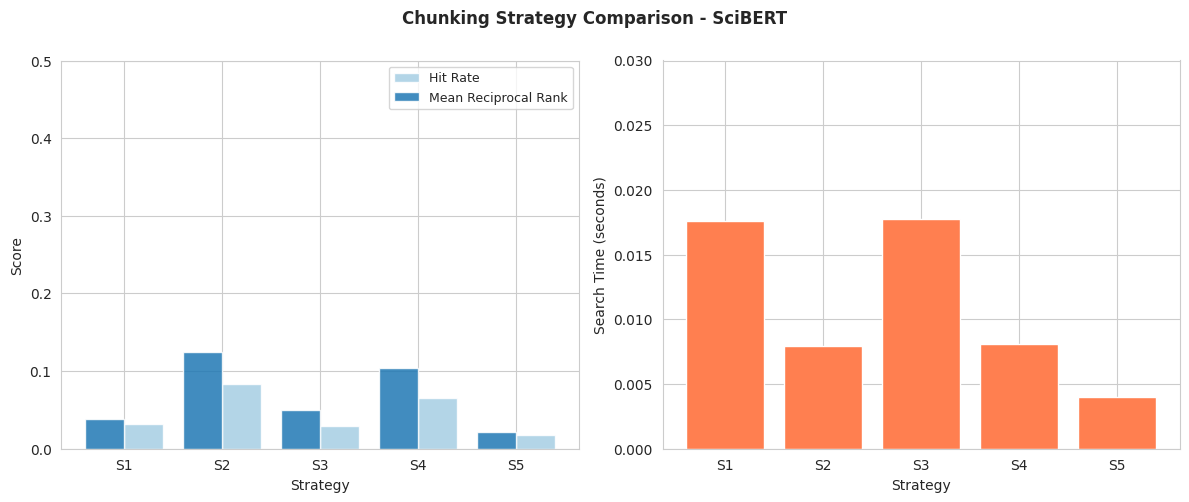

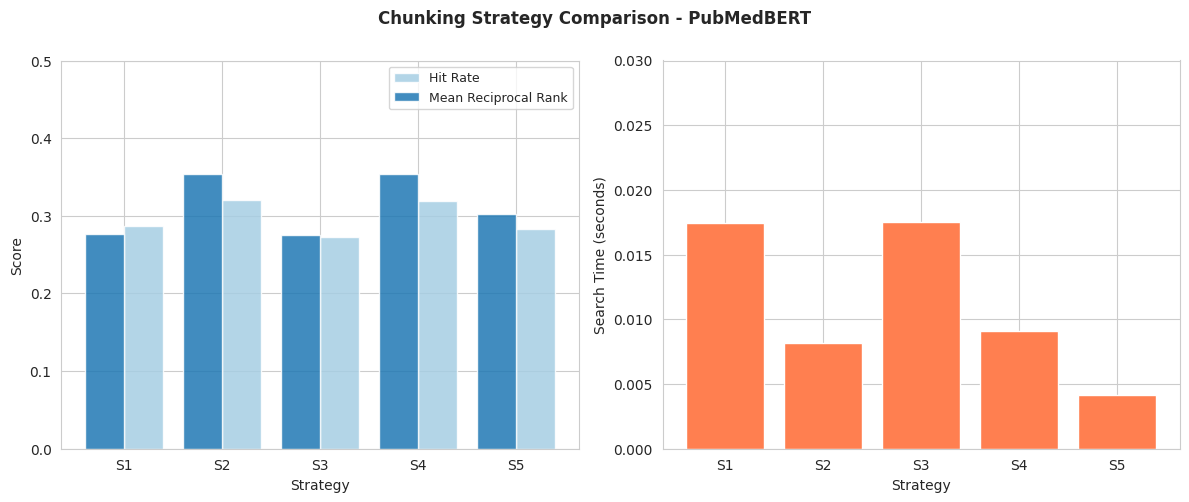

In [12]:
models = [
    ('specter2', specter2_df, 'SPECTER2'),
    ('specter', specter_df, 'SPECTER'),
    ('scincl', scincl_df, 'SciNCL'),
    ('scibert', scibert_df, 'SciBERT'),
    ('pubmedbert', pubmedbert_df, 'PubMedBERT')
]
total_queries = 722
for model_key, model_df, model_name in models:
    figure, axes = plt.subplots(1, 2, figsize=(12, 5))
    figure.suptitle(f"Chunking Strategy Comparison - {model_name}", y=0.995, fontsize=12, fontweight="bold")
    
    ax = axes[0]
    x = np.arange(len(model_df))
    width = 0.2
    ax.bar(x + width, model_df["hit_rate"], label="Hit Rate", width=0.4, alpha=0.85)
    ax.bar(x - width, model_df["mrr_mean"], label="Mean Reciprocal Rank", width=0.4, alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels([code_to_strategy_num_mapping[strategy] for strategy in model_df['strategy']])
    ax.set_ylabel("Score")
    ax.set_xlabel("Strategy")
    ax.set_ylim(0, 0.5)
    ax.legend(fontsize=9)
    
    ax = axes[1]
    search_time = runtime_metrics_df[runtime_metrics_df['embedding_model'] == model_key][['strategy', 'search_time_s']]
    x = np.arange(len(search_time))
    ax.bar(x, search_time['search_time_s'] / total_queries, color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels([code_to_strategy_num_mapping[strategy] for strategy in search_time['strategy']])
    ax.set_ylim(0, 0.03)
    ax.set_ylabel("Search Time (seconds)")
    ax.set_xlabel("Strategy")
    
    plt.tight_layout()
    # plt.savefig(f'{model_key}_comparison.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Embedding Model')

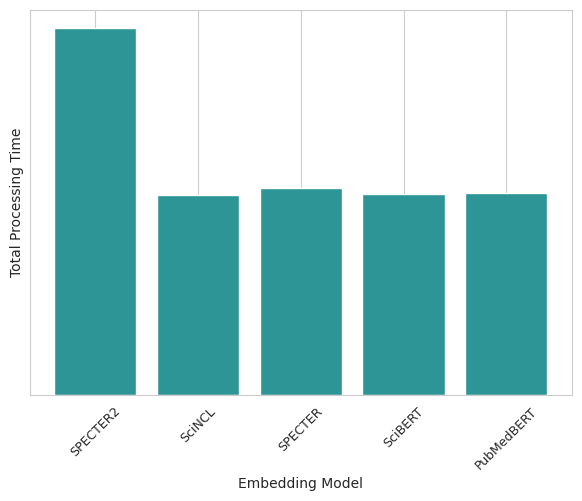

In [13]:
model_id_model_name_mapping = {'specter2': 'SPECTER2', 
                               'specter': 'SPECTER', 
                               'scincl': 'SciNCL', 
                               'scibert': 'SciBERT', 
                               'pubmedbert': 'PubMedBERT'}


figure, ax = plt.subplots(1,1,figsize=(7,5))
total_time = runtime_metrics_df[['embedding_model','total_embedding_model_time_s']]
total_time = total_time.drop_duplicates()
x = np.arange(len(total_time))
ax.bar(x, total_time['total_embedding_model_time_s'], color="#2D9596")
ax.set_xticks(x)
ax.set_xticklabels([model_id_model_name_mapping[model_id] for model_id in total_time['embedding_model']], rotation=45, fontsize=9)
ax.set_yticks([])
ax.set_ylabel("Total Processing Time")
ax.set_xlabel("Embedding Model")

## Final Verdict

`SciNCL` embedding model with with `recursive text splitting` with a `chunk Size of 512` and `chunk overlap of 0` provides the best tradeoff between quality and latency.
